<a href="https://colab.research.google.com/github/bl4ckf0xk/ModelX_First_Order/blob/main/ModelX_Model_With_Model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, recall_score, precision_score
import joblib

In [ ]:
!pip install shap
import shap

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Dementia Prediction Dataset.csv'
RANDOM_STATE = 42
TARGET = 'DEMENTED'
SUBJECT_ID = 'NACCID'  # change if your identifier column has a different name

In [ ]:
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found at {path}. Upload it to Colab or set DATA_PATH correctly.")
    df = pd.read_csv(path)
    return df

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

# Impute for selection (temporary)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)
mi = mutual_info_classif(X_imputed, df[TARGET])
mi_df = pd.DataFrame({'Feature': features, 'MI': mi}).sort_values('MI', ascending=False)
print(mi_df)  # Use top N features; drop if MI < 0.01

# Update FINAL_FEATURES based on this (e.g., keep top 10-15)
FINAL_FEATURES = mi_df[mi_df['MI'] > 0.01]['Feature'].tolist()  # Example threshold

In [ ]:
NON_MEDICAL_WHITELIST = [
    # Subject demographics
    'BIRTHYR', 'BIRTHMO', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX',
    'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX',
    'EDUC', 'MARISTAT', 'PRIMLANG', 'PRIMLANX', 'RESIDENC', 'HANDED', 'NACCLIVS', 'INDEPEND',
    # Co-participant
    'INBIRYR', 'INBIRMO', 'INSEX', 'INHISP', 'INHISPOR', 'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'NEWINF',
    # Lifestyle
    'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ',
    # Visit metadata
    'NACCVNUM', 'NACCNVST', 'NACCAVST', 'NACCDAYS', 'NACCFDYS', 'PACKET', 'FORMVER', 'TELCOV', 'TELMOD',
    # Family history (non-genetic fields)
    'NACCFAM', 'NACCMOM', 'NACCDAD'
]

In [ ]:
print('Loading data...')
df = load_data(DATA_PATH)
print('Rows:', len(df), 'Columns:', len(df.columns))

Loading data...


/tmp/ipython-input-175837067.py:4: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Rows: 195196 Columns: 1024


In [ ]:
# Ensure target and subject id exist
if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found in dataset.")
if SUBJECT_ID not in df.columns:
    raise KeyError(f"Subject ID column '{SUBJECT_ID}' not found in dataset.")

# Reduce to columns we care about (keep subject id and target)
available_features = [c for c in NON_MEDICAL_WHITELIST if c in df.columns]
print(f'Using {len(available_features)} non-medical features (of {len(NON_MEDICAL_WHITELIST)} whitelist)')

# Warn about missing whitelist columns
missing = set(NON_MEDICAL_WHITELIST) - set(available_features)
if missing:
    print('Warning: The following whitelist columns were not found in your CSV and will be skipped:')
    print(sorted(list(missing)))

keep_cols = [SUBJECT_ID, TARGET] + available_features
df = df[keep_cols].copy()

Using 55 non-medical features (of 55 whitelist)


Handle NACC special codes -> convert common missing codes to NaN

In [ ]:
# Typical NACC codes: -4 = Not applicable, -1 or 9 = Unknown, 88/99 = other/missing depending on variable
NA_CODES = [-4, -1, 8, 9, 88, 95, 96, 97, 98, 99, 999]
for v in df.columns:
    if df[v].dtype.kind in 'biufc':
        df[v] = df[v].replace(NA_CODES, np.nan)
    else:
        # for object/string fields, keep as-is and handle missing later
        df[v] = df[v].replace([str(x) for x in NA_CODES], np.nan)

# Also treat target code '9' explicitly as NaN (unknown)
df[TARGET] = df[TARGET].replace(9, np.nan)

# Drop rows where target is missing
df = df[df[TARGET].notna()].copy()
print('After dropping unknown target, rows:', len(df))

After dropping unknown target, rows: 195196


Feature engineering

In [ ]:
# AGE if present; compute age-at-visit if possible using BIRTHYR and an approximate VISITYR if available.
# If NACCAGE exists, prefer it. Otherwise derive AGE from BIRTHYR with caveat.
if 'BIRTHYR' in df.columns and 'NACCFDYS' in df.columns:
    df['AGE'] = (df['NACCFDYS'] / 365.25) + (2023 - df['BIRTHYR'])
elif 'NACCAGE' in df.columns:
    df['AGE'] = df['NACCAGE']
else:
    df['AGE'] = np.nan

df['AGE_BIN'] = pd.cut(df['AGE'], bins=[0, 60, 70, 80, 120], labels=['<60', '60-70', '70-80', '80+'])

# Pack-years and simple booleans
if 'PACKSPER' in df.columns and 'SMOKYRS' in df.columns:
    df['PACK_YEARS'] = df['PACKSPER'] * df['SMOKYRS']
else:
    df['PACK_YEARS'] = np.nan

if 'TOBAC30' in df.columns and 'TOBAC100' in df.columns:
    df['EVER_SMOKE'] = ((df['TOBAC30'] == 1) | (df['TOBAC100'] == 1)).astype(int)
else:
    df['EVER_SMOKE'] = pd.Series([pd.NA] * len(df))

# Heavy alcohol heuristic
if 'ALCFREQ' in df.columns:
    # interpret codes: (user should adjust according to their codebook)
    # treat high frequency codes (e.g., weekly/daily) as heavy
    df['HEAVY_ALCOHOL'] = df['ALCFREQ'].apply(lambda x: 1 if (pd.notna(x) and float(x) >= 5) else 0).astype('Int64')
else:
    df['HEAVY_ALCOHOL'] = pd.Series([pd.NA] * len(df))

# Years in study
if 'NACCDAYS' in df.columns:
    df['YEARS_IN_STUDY'] = df['NACCDAYS'] / 365.25
else:
    df['YEARS_IN_STUDY'] = np.nan

# Lives alone bool from NACCLIVS (if 1 = lives alone in your version)
if 'NACCLIVS' in df.columns:
    df['LIVES_ALONE'] = df['NACCLIVS'].apply(lambda x: 1 if x == 1 else 0).astype('Int64')
else:
    df['LIVES_ALONE'] = pd.Series([pd.NA] * len(df))

df['MARRIED'] = (df['MARISTAT'] == 1).astype('Int64')  # 1 = married

# Education level (simplify)
df['HIGH_EDUC'] = (df['EDUC'] >= 16).astype('Int64')  # college+

# Family history of dementia
df['FAM_DEMENTIA'] = ((df['NACCMOM'] == 1) | (df['NACCDAD'] == 1)).astype('Int64')

df['AGE_EDUC_INTERACT'] = df['AGE'] * df['EDUC']
df['AGE_SMOKE_INTERACT'] = df['AGE'] * df['EVER_SMOKE']

# Final feature list (keep engineered features)
engineered = ['AGE', 'PACK_YEARS', 'EVER_SMOKE', 'HEAVY_ALCOHOL', 'YEARS_IN_STUDY', 'LIVES_ALONE', 'MARRIED', 'HIGH_EDUC', 'FAM_DEMENTIA', 'PACK_YEARS', 'EVER_SMOKE']
for e in engineered:
    if e not in df.columns:
        df[e] = np.nan

Final feature set building (numeric vs categorical)

In [ ]:
FINAL_FEATURES = [
    'AGE', 'SEX', 'EDUC', 'MARISTAT', 'RESIDENC', 'INDEPEND',
    'LIVES_ALONE', 'MARRIED', 'HIGH_EDUC', 'EVER_SMOKE', 'PACK_YEARS', 'ALCFREQ',
    'FAM_DEMENTIA', 'NACCMOM', 'NACCDAD', 'HISPANIC', 'RACE', 'PRIMLANG',
    'AGE_BIN', 'HEAVY_ALCOHOL', 'YEARS_IN_STUDY', 'AGE_EDUC_INTERACT', 'AGE_SMOKE_INTERACT'
]

In [ ]:
# Start from available_features (from whitelist) and add engineered numeric features
features = available_features.copy()
# Remove potential duplicates if present
for c in engineered:
    if c not in features:
        features.append(c)

# Remove subject id and target if present mistakenly
features = [f for f in features if f not in [SUBJECT_ID, TARGET]]

# Separate numeric and categorical heuristically
numeric_feats = []
categorical_feats = []
for f in features:
    if pd.api.types.is_numeric_dtype(df[f]) or f in engineered:
        numeric_feats.append(f)
    else:
        categorical_feats.append(f)

print('Numeric features:', len(numeric_feats))
print('Categorical features:', len(categorical_feats))

Numeric features: 50
Categorical features: 11


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

X = df[FINAL_FEATURES]
y = df[TARGET].astype(int)

print(y.value_counts(normalize=True))  # Check imbalance, e.g., 70% not demented

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=df['NACCID']))

X_train = df.iloc[train_idx][FINAL_FEATURES]
X_test  = df.iloc[test_idx][FINAL_FEATURES]
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

In [ ]:
# If imbalanced (e.g., <30% positive), add to models (e.g., for XGBoost)
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

Preprocessing pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['AGE', 'EDUC', 'PACK_YEARS']
categorical_features = [f for f in FINAL_FEATURES if f not in numeric_features]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), categorical_features)
])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings; warnings.filterwarnings('ignore')

models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'Logistic': LogisticRegression(max_iter=1000)
}

param_grids = {
    'XGBoost': {
        'model__n_estimators': [200, 300, 500],
        'model__max_depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.8, 1.0],
        'model__scale_pos_weight': [1, scale_pos_weight]
    },
    'LightGBM': {
        'model__n_estimators': [200, 300],
        'model__max_depth': [4, 6],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [31, 63]
    },
    'RandomForest': {
        'model__n_estimators': [200, 300],
        'model__max_depth': [6, 8, 10],
        'model__min_samples_split': [2, 5]
    },
    'Logistic': {
        'model__C': [0.1, 1.0, 10.0]
    }
}

Model pipeline (XGBoost) + hyperparameter search

In [ ]:
!pip install scikit-optimize catboost

In [ ]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedGroupKFold
from catboost import CatBoostClassifier

# Add to models
models['CatBoost'] = CatBoostClassifier(random_state=42, verbose=0)
param_grids['CatBoost'] = {
    'model__iterations': [200, 500],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.1]
}

# Custom scorer (weighted F1 for imbalance)
scorer = make_scorer(f1_score)

# Use BayesSearchCV instead of RandomizedSearchCV
search = BayesSearchCV(pipeline, param_grids[name], n_iter=20, cv=StratifiedGroupKFold(n_splits=3), scoring=scorer, random_state=42, n_jobs=-1)

# After fitting, evaluate more metrics
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Recall: {recall_score(y_test, y_pred)}, Precision: {precision_score(y_test, y_pred)}")

In [ ]:
best_models = {}
results = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    search = RandomizedSearchCV(
        pipeline, param_grids[name], n_iter=10,
        cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_models[name] = search.best_estimator_
    pred_proba = search.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred_proba)
    results[name] = auc
    print(f"{name} AUC: {auc:.4f}")


Tuning XGBoost...
XGBoost AUC: 0.9244

Tuning LightGBM...
[LightGBM] [Info] Number of positive: 46175, number of negative: 109583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 155758, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296453 -> initscore=-0.864244
[LightGBM] [Info] Start training from score -0.864244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [ ]:
# best_name = max(results, key=results.get)
# final_model = best_models[best_name]
# print(f"\nBest Model: {best_name} (AUC: {results[best_name]:.4f})")

# # Calibrate probabilities (for reliable % output)
# from sklearn.calibration import CalibratedClassifierCV

# calibrated = CalibratedClassifierCV(final_model, method='sigmoid', cv='prefit')
# calibrated.fit(X_train, y_train)

best_name = max(results, key=results.get)
final_model = best_models[best_name]          # <-- a Pipeline: prep → model
print(f"Best Model: {best_name} (AUC: {results[best_name]:.4f})")

from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(
    final_model,               # <-- pass the **pipeline**, not the raw estimator
    method='sigmoid',          # Platt scaling
    cv='prefit'                # we already fitted the pipeline on X_train
)
calibrated.fit(X_train, y_train)   # only fits the calibrator, not the base model

Best Model: LightGBM (AUC: 0.9246)


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['AGE',
                                                                                    'EDUC',
                                                                                    'PACK_YEARS']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                                   ['SEX',
                                                                                    'MARISTAT',
                                                                                    'RESIDENC',
                                                                                    'INDEPEND',
                                                                                    'LIVES_ALONE',
                                                                                    'MARRIED',
                                                                                    'HIGH_EDUC',
                                                                                    'EVER_SMOKE',
                                                                                    'ALCFREQ',
                                                                                    'FAM_DEMENTIA',
                                                                                    'NACCMOM',
                                                                                    'NACCDAD',
                                                                                    'HISPANIC',
                                                                                    'RACE',
                                                                                    'PRIMLANG'])])),
                                                 ('model',
                                                  LGBMClassifier(learning_rate=0.05,
                                                                 max_depth=4,
                                                                 n_estimators=300,
                                                                 random_state=42))]))

In [ ]:
raw_pipeline = calibrated.calibrated_classifiers_[0].estimator

raw_model = raw_pipeline.named_steps['model']   # XGBoost / LightGBM / RF
prep      = raw_pipeline.named_steps['prep']    # ColumnTransformer

In [ ]:
X_train_s = prep.transform(X_train)               # scipy sparse → keep it
X_test_s  = prep.transform(X_test.iloc[:100])

# If the transformer returns a sparse matrix, convert once for SHAP
if hasattr(X_train_s, "toarray"):
    X_train_s = X_train_s.toarray()
    X_test_s  = X_test_s.toarray()

In [ ]:
# After fitting best model
explainer = shap.Explainer(best_models['XGBoost']['model'], preprocessor.transform(X_train))  # After prep
shap_values = explainer(preprocessor.transform(X_test))

# Global summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

# In predict_dementia_risk, add local explanation
input_transformed = preprocessor.transform(df_input)
shap_val = explainer(input_transformed)
top_factors = pd.DataFrame({'Feature': FINAL_FEATURES, 'SHAP': shap_val.values[0]}).sort_values('SHAP', key=abs, ascending=False).head(3)
result['explanation'] = f"Top risk factors: {', '.join(top_factors['Feature'].tolist())}"

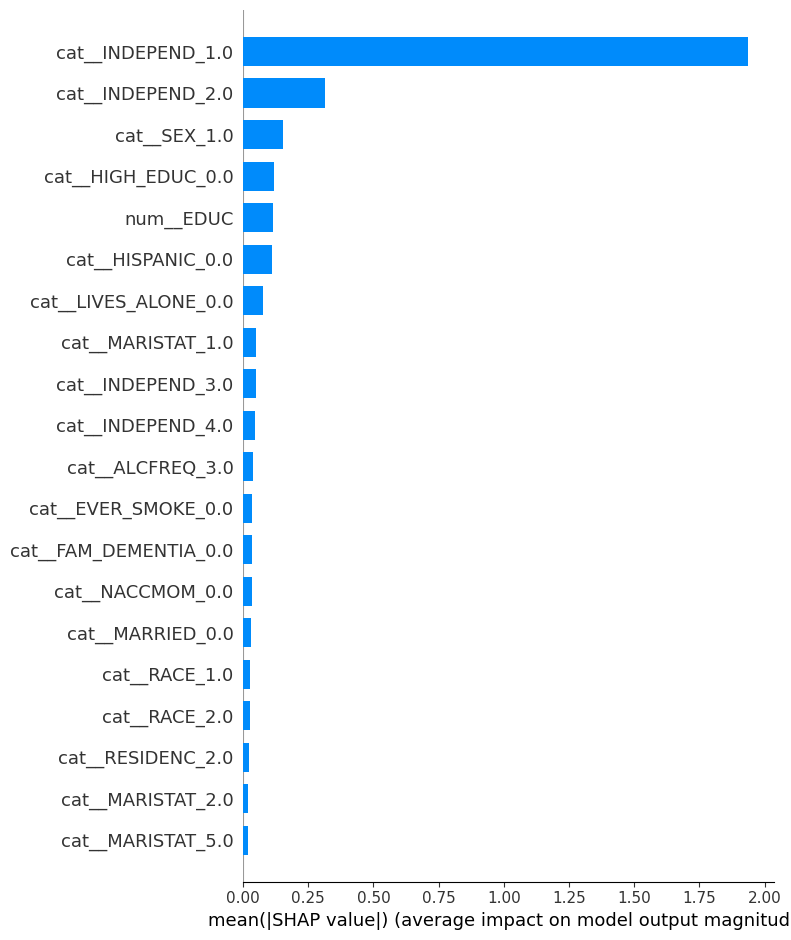

In [ ]:
feature_names = prep.get_feature_names_out()

# --------------------------------------------------------------
# 6. SHAP explainer + summary bar plot
# --------------------------------------------------------------
import shap

explainer   = shap.TreeExplainer(raw_model, X_train_s)   # background = train
shap_vals   = explainer.shap_values(X_test_s)

# XGBoost/LightGBM return [neg, pos]; take the positive class
if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]

shap.summary_plot(
    shap_vals,
    X_test_s,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

In [ ]:
import joblib
joblib.dump(calibrated, "dementia_risk_model_final.pkl")
print("Final model saved!")

Final model saved!


In [ ]:
# Load model
model = joblib.load("dementia_risk_model_final.pkl")

def predict_dementia_risk(user_data):
    """
    user_data = {
        "age": 72,
        "education_years": 12,
        "lives_alone": True,
        "ever_smoked": False,
        "family_dementia": True,
        "sex": "Female",
        ...
    }
    """
    # Create DataFrame with all expected columns
    df_input = pd.DataFrame(columns=FINAL_FEATURES)
    df_input.loc[0] = np.nan

    # Map user input
    df_input.loc[0, 'AGE'] = user_data['age']
    df_input.loc[0, 'EDUC'] = user_data['education_years']
    df_input.loc[0, 'LIVES_ALONE'] = 1 if user_data['lives_alone'] else 0
    df_input.loc[0, 'EVER_SMOKE'] = 1 if user_data['ever_smoked'] else 0
    df_input.loc[0, 'FAM_DEMENTIA'] = 1 if user_data['family_dementia'] else 0
    df_input.loc[0, 'SEX'] = 1 if user_data['sex'] == 'Male' else 2  # match dataset codes

    # Predict
    prob = float(model.predict_proba(df_input)[0, 1]) * 100
    prob = round(prob, 2)
    label = "At risk" if prob > 50 else "Not at risk"

    return {
        "risk_percent": round(prob, 2),
        "label": label,
        "advice": "Consider lifestyle changes" if prob > 30 else "Keep up healthy habits!"
    }

# Example
user = {
    "age": 78,
    "education_years": 10,
    "lives_alone": True,
    "ever_smoked": True,
    "family_dementia": True,
    "sex": "Female"
}

result = predict_dementia_risk(user)
print(result)

{'risk_percent': 9.2, 'label': 'Not at risk', 'advice': 'Keep up healthy habits!'}
